# Расчет минимального размера выборок для A/B-теста

У нас есть данные по транзакциям пользователей. Мы хотим провести a/b-тест относительно продаж (gmv). Тест двусторонний. Какое минимальное число пользователей необходимо взять в эксперимент, если мы хотим иметь:
- уровень значимости не более 5%;
- мощность не менее 80%;
- минимальный эффекс, который мы хотим зарегистрировать - 1%?

Хотим разбиение теста и контроля - 1:3.  
Будем предполагать, что дисперсии в обеих группах одинаковые.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as sps
from math import ceil

## Чтение и проверка данных

In [2]:
df = pd.read_csv('./data_ignored/synthetic_gmv_data_1.1.csv')
df.head()

,user_id,gmv
0,guo0pdwqvg,506
1,guo0pdwqvg,760
2,guo0pdwqvg,633
3,guo0pdwqvg,506
4,guo0pdwqvg,760


In [3]:
df.isna().sum()

user_id    0
gmv        0
dtype: int64

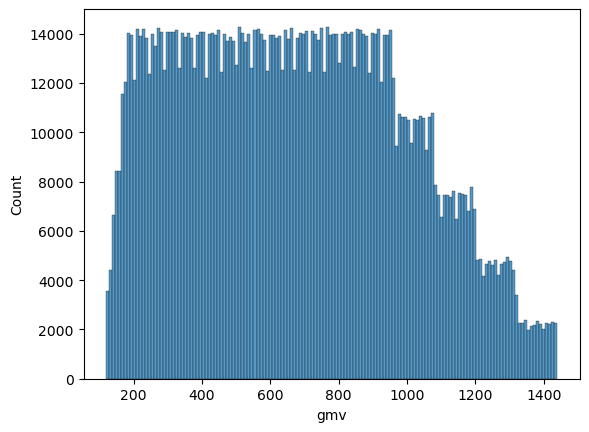

In [4]:
sns.histplot(df.gmv);

Пропуски в наших данных вычищены, а выбросов не видно.

## Расчет размера выборок

Посчитаем "поюзерные" продажи на основе имеющихся данных, а затем вычислим их среднюю и дисперсию:

In [5]:
mean_metric = df.groupby('user_id').sum().mean()
var_metric = df.groupby('user_id').sum().var()
mean_metric, var_metric

(gmv    2750.846709
 dtype: float64,
 gmv    3.646228e+06
 dtype: float64)

Воспользуемся формулами для расчета размера выборки:
$$m > \dfrac{(z_{1-\alpha/2} + z_{1-\beta})^2 (1 + k)\sigma^2}{e^2}$$

$$n > \dfrac{(z_{1-\alpha/2} + z_{1-\beta})^2 (1 + k)\sigma^2}{ke^2}$$
, где n -  количество пользователей в тестовой выборке, m - в контрольной, а k = m / n

In [6]:
def control_group_size(var_df, effect, k = 1, alpha = 0.05, beta = 0.2):
    """вычисляет минимальный объем контрольной группы"""
    dist = sps.norm(loc=0, scale=1)  # стандартное z-распределение
    return ((dist.ppf(1 - alpha/2) + dist.ppf(1- beta))**2) * (1 + k) * var_df / effect**2

In [ ]:
effect = mean_metric * 0.03  # mde в 3% мы хотим увидеть
k = 3  # отношение объема контрольной группы к тестовой
m = control_group_size(var_metric, effect, k = k)  # объем контрольной группы
n = m / k  # объем тестовой группы
print(
        f'В тестовой группе должно быть {ceil(n.iloc[0])} пользователей, \n'\
        f'В контрольной группе должно быть {ceil(m.iloc[0])} пользователей, \n'\
        f'Всего - {ceil(n.iloc[0]) + ceil(m.iloc[0])} пользователей'
)

В тестовой группе должно быть 5603 пользователей, 
В контрольной группе должно быть 16809 пользователей, 
Всего - 22412 пользователей
